## Iowa Liquor Sales 


In this notebook I will be using the pandas data transformation functionality 


**Context of the data:**

    The state of Iowa provides many data sets on their website, which contains transactions for all stores that have a class E liquor license. 

---

#### Package imports

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import ceil

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Loading the Data File

---

In [2]:
# check the iowa file location for your computer 
iowa_file = './datasets/iowa_liquor/Iowa_Liquor_sales_sample_10pct.csv'

iowa = pd.read_csv(iowa_file)
print "Dataframe is of size: " + str(iowa.values.nbytes / 10**6) + "MB"

Dataframe is of size: 39MB


### Initial overview of the data

---

In [3]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: float64(4), int64(

In [4]:
iowa.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


### Clean The Dataset

---



Above we find out that we have approx. 271-thousand rows of data and some columns containing null values. Because it's such a large sample size, the simplest approach would be removing any row with a null value. And so we test (below) what percentage of the data would remain if we take this approach:

In [5]:
not_null = round(100 * (iowa[~ pd.isnull(iowa).any(axis=1)].shape[0] / float(iowa.shape[0]) ), 2)
print "{}% of data remaining".format(not_null)

99.37% of data remaining


In [6]:
## Removing all rows with null values...Reasonable, given we lose < 1% of the data
iowa = iowa[~ pd.isnull(iowa).any(axis=1)].reset_index(drop=True)
iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269258 entries, 0 to 269257
Data columns (total 18 columns):
Date                     269258 non-null object
Store Number             269258 non-null int64
City                     269258 non-null object
Zip Code                 269258 non-null object
County Number            269258 non-null float64
County                   269258 non-null object
Category                 269258 non-null float64
Category Name            269258 non-null object
Vendor Number            269258 non-null int64
Item Number              269258 non-null int64
Item Description         269258 non-null object
Bottle Volume (ml)       269258 non-null int64
State Bottle Cost        269258 non-null object
State Bottle Retail      269258 non-null object
Bottles Sold             269258 non-null int64
Sale (Dollars)           269258 non-null object
Volume Sold (Liters)     269258 non-null float64
Volume Sold (Gallons)    269258 non-null float64
dtypes: float64(4), int64(

In [7]:
money_cols = ['State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']
iowa[money_cols].head()

,State Bottle Cost,State Bottle Retail,Sale (Dollars)
0,$4.50,$6.75,$81.00
1,$13.75,$20.63,$41.26
2,$12.59,$18.89,$453.36
3,$9.50,$14.25,$85.50
4,$7.20,$10.80,$129.60


In [8]:
## Converting dollar strings to floats and renaming their columns ##

for col in money_cols:
    iowa[col] = iowa[col].apply(lambda x: float(x.replace('$','')))

money_cols2 = ['State Bottle Cost ($)', 'State Bottle Retail ($)', 'Sale ($)']
iowa.rename(columns={x:y for x, y in zip(money_cols, money_cols2)}, inplace=True)
iowa[money_cols2].head()

,State Bottle Cost ($),State Bottle Retail ($),Sale ($)
0,4.50,6.75,81.00
1,13.75,20.63,41.26
2,12.59,18.89,453.36
3,9.50,14.25,85.50
4,7.20,10.80,129.60


In [9]:
# Converting Date column to datetime
# & creating Year and Month columns
iowa.Date = pd.to_datetime(iowa.Date, format='%m/%d/%Y')

iowa['Year'] = iowa.Date.dt.year
iowa['Month'] = iowa.Date.dt.month

# Creating a profit column
iowa['Profit ($)'] = (iowa['State Bottle Retail ($)'] - iowa['State Bottle Cost ($)']) * iowa['Bottles Sold']

In [10]:
# Drop columns I don't intend on using
iowa = iowa.drop(['County Number', 'Category', 'Item Number'], axis=1)

In [11]:
iowa.columns

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County',
       u'Category Name', u'Vendor Number', u'Item Description',
       u'Bottle Volume (ml)', u'State Bottle Cost ($)',
       u'State Bottle Retail ($)', u'Bottles Sold', u'Sale ($)',
       u'Volume Sold (Liters)', u'Volume Sold (Gallons)', u'Year', u'Month',
       u'Profit ($)'],
      dtype='object')

### Filter/Adjust The Store Data

---

Some stores may have opened or closed in 2015. These stores will have incorrect yearly summary statistics since they were not open the full year. Thus, I am filtering them out 

In [12]:
# Grouping iowa stores to find their min/max dates
store_dates = iowa.groupby('Store Number')['Date'].agg([np.min, np.max]).reset_index() 

strt_2015 = datetime(2015, 1, 31)
end_2015 = datetime(2015, 12, 1)

mask = (store_dates['amin'] < strt_2015) & (store_dates['amax'] > end_2015)

print 'Unique Stores: {}'.format(len(store_dates))
print 'Unique Stores Open all 2015: {}'.format(len(store_dates[mask]['Store Number']))


Unique Stores: 1378
Unique Stores Open all 2015: 1084


In [13]:
## Original DataFrame: 270,955
## Cleaned DataFrame: 269,258
## Stores Opened all Yr. DataFrame: 251,827

## 93% of data from the original. Rates: 100% -> 99.4% -> 93%

iowa = iowa[iowa['Store Number'].isin(store_dates[mask]['Store Number'])]

### Proposals For New Tax Rates

---

Scenario: I am a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and has assigned me to the project.

#### Calculating yearly liquor sales for each store in 2015.

In [14]:
## Use 'Sale ($) column'
mask = iowa['Year'] == 2015
iowa_2015 = iowa[mask]
iowa_2015.groupby(by='Store Number')['Sale ($)'].sum().reset_index().head()

,Store Number,Sale ($)
0,2106,146038.70
1,2113,9310.22
2,2130,111583.91
3,2152,7721.08
4,2178,24324.18


#### Calculating the profit each store is making in 2015.

In [15]:
liq_store_profit = iowa_2015.groupby(by='Store Number')['Profit ($)'].sum().reset_index()
liq_store_profit.head()

,Store Number,Profit ($)
0,2106,48742.20
1,2113,3109.04
2,2130,37229.32
3,2152,2587.53
4,2178,8165.70


#### Investigating which Iowa counties are making the most profit on liquor per gallon in 2015.

In [16]:
iowa_2015['Profit/Gal'] = iowa_2015['Profit ($)'] / iowa_2015['Volume Sold (Gallons)'] 

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
county_profit = iowa_2015.groupby(by=['County'])['Profit/Gal'].mean().reset_index()
county_profit = county_profit.sort_values(by='Profit/Gal', ascending=False).reset_index(drop=True)
county_profit.columns = ['County', 'Avg. Profit_Gal']
county_profit.head()

,County,Avg. Profit_Gal
0,Polk,25.025381
1,Johnson,24.287837
2,Scott,24.138063
3,Jefferson,24.131455
4,Buena Vista,23.713147


In [19]:
print 'Avg County Profits/Gal (min: ${}, max: ${})'.format(round(county_profit.loc[:,'Avg. Profit_Gal'].min(),2), round(county_profit.loc[:,'Avg. Profit_Gal'].max(),2))

Avg County Profits/Gal (min: $14.9, max: $25.03)


#### Does profit scale proportionally to store size?

Size of a store can be defined as the total gallons sold in 2015. Is the profit to store size ratio increasing as store size increases? Decreasing? Consistent?

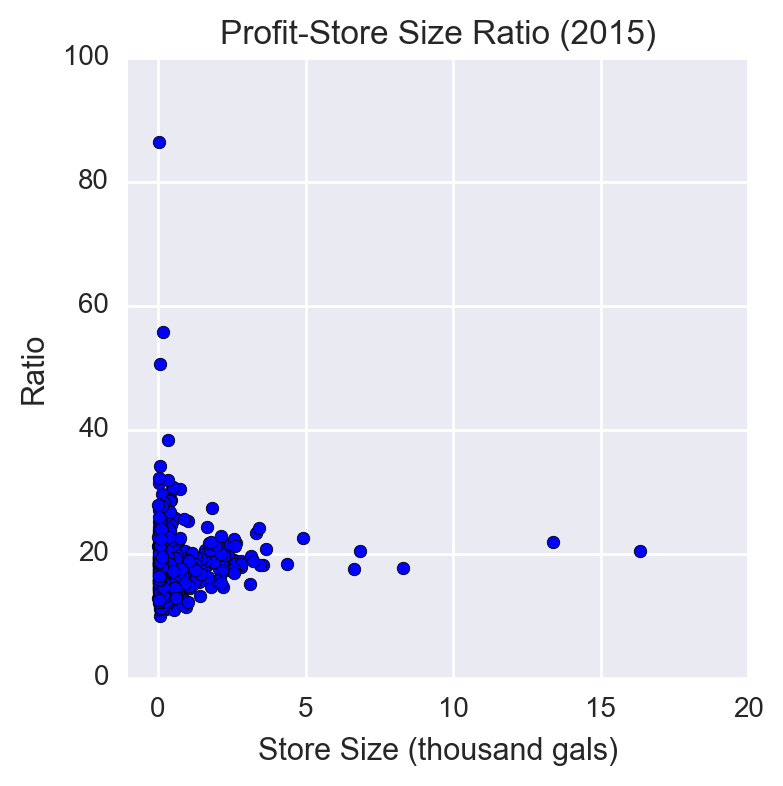

In [20]:
df = iowa_2015.groupby(by='Store Number')[['Volume Sold (Gallons)', 'Profit ($)']].sum().reset_index()
df['Ratio'] = df['Profit ($)']/df['Volume Sold (Gallons)']

fig, ax = plt.subplots(figsize=(4,4))

ax.set_title('Profit-Store Size Ratio (2015)')
ax.set_xlabel('Store Size (thousand gals)')
ax.set_ylabel('Ratio')
ax.set_xlim(-1,20)
plt.scatter(x=df['Volume Sold (Gallons)']/float(1000), y=df['Ratio'])
plt.show()

### Creating A Broader Category for Liquor Type.

Liquor types are pretty granular in this dataset. I will create a column that categorizes these types into a smaller amount of categories.

In [21]:
print 'Data has {} unique liquor categories'.format(len(iowa_2015['Category Name'].unique()))
liquor = np.sort(iowa_2015['Category Name'].unique())

Data has 70 unique liquor categories


In [22]:
# Helper Function to clean Liquor strings
def replace_all(text, dic):
    for i, j in dic.iteritems():
        text = text.replace(i, j)
    return text

In [23]:
# Combine liq into one big string
liq_words = reduce(lambda x,y: x + ' ' + y, liquor)

# Replace special characters in the string
rdict = {'-': '', '&': '', '.':''}
liq_words = replace_all(liq_words, rdict)

# Create list of all words, sort, and remove leftover ''s
liq_words = liq_words.split(' ')
liq_words.sort()
liq_words = filter(lambda x: x != '', liq_words)

# Unique array of each word
liq_words = np.unique(liq_words)

In [24]:
liq_words

array(['100', '80', 'ALCOHOL', 'ALMOND', 'AMARETTO', 'AMERICAN',
       'ANISETTE', 'APPLE', 'APRICOT', 'BARBADOS', 'BARREL', 'BEER',
       'BLACKBERRY', 'BLENDED', 'BOND', 'BOTTLED', 'BOURBON', 'BRANDIES',
       'BUTTERSCOTCH', 'CACAO', 'CANADIAN', 'CHERRY', 'CINNAMON',
       'COCKTAILS', 'COFFEE', 'CORDIALS', 'CORN', 'CREAM', 'CREME', 'DARK',
       'DE', 'DECANTERS', 'DISTILLED', 'DRY', 'FLAVORED', 'FRUIT', 'GINS',
       'GRAPE', 'GREEN', 'HIGH', 'IMPORTED', 'IN', 'IRISH', 'ISLANDS',
       'JAMAICA', 'LIQUEUR', 'LIQUEURS', 'LOW', 'MALT', 'MENTHE', 'MISC',
       'MISCELLANEOUS', 'OTHER', 'PACKAGES', 'PEACH', 'PEPPERMINT',
       'PROOF', 'PUERTO', 'RASPBERRY', 'RICO', 'ROCK', 'ROOT', 'RUM',
       'RYE', 'SCHNAPPS', 'SCOTCH', 'SEC', 'SINGLE', 'SLOE', 'SPEARMINT',
       'SPECIALTY', 'SPICED', 'SPIRITS', 'STRAIGHT', 'STRAWBERRY',
       'TENNESSEE', 'TEQUILA', 'TRIPLE', 'TROPICAL', 'VIRGIN', 'VODKA',
       'WATERMELON', 'WHISKEY', 'WHISKIES', 'WHITE'], 
      dtype='|S13')

In [25]:
liq_cats = ['AMARETTO', 'AMERICAN ALCOHOL', 'BOURBON', 'BRANDIES', 
            'COCKTAILS', 'COFFEE', 'CREAM', 'CORDIALS', 'DISTILLED SPIRITS', 
            'GINS', 'RUM', 'SCHNAPPS', 'SCOTCH', 'SPECIALTY', 'TEQUILA', 
            'TRIPLE SEC', 'VODKA', 'WHISKEY']

In [26]:
liq_key_dict = {cat:cat for cat in liq_cats}
liq_key_dict['WHISKEY'] = 'WHISK'
liq_key_dict['CREAM'] = 'CRE'
liq_key_dict['DISTILLED SPIRITS'] = 'DISTILLED'
liq_key_dict

{'AMARETTO': 'AMARETTO',
 'AMERICAN ALCOHOL': 'AMERICAN ALCOHOL',
 'BOURBON': 'BOURBON',
 'BRANDIES': 'BRANDIES',
 'COCKTAILS': 'COCKTAILS',
 'COFFEE': 'COFFEE',
 'CORDIALS': 'CORDIALS',
 'CREAM': 'CRE',
 'DISTILLED SPIRITS': 'DISTILLED',
 'GINS': 'GINS',
 'RUM': 'RUM',
 'SCHNAPPS': 'SCHNAPPS',
 'SCOTCH': 'SCOTCH',
 'SPECIALTY': 'SPECIALTY',
 'TEQUILA': 'TEQUILA',
 'TRIPLE SEC': 'TRIPLE SEC',
 'VODKA': 'VODKA',
 'WHISKEY': 'WHISK'}

In [27]:
# Helper function to return a general category
def liq_xform_cat(cat_name, word_dict):
    for idx, val in word_dict.items():
        if val in cat_name:
            return idx
    return 'OTHER'

In [28]:
# Applying the above function to generalize category
iowa_2015.loc[:, 'Gen Category'] = iowa_2015.loc[:,'Category Name'].apply(lambda x: liq_xform_cat(x, liq_key_dict))

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
iowa_2015[['Category Name', 'Gen Category']].head(10)

,Category Name,Gen Category
0,APRICOT BRANDIES,BRANDIES
4,VODKA 80 PROOF,VODKA
5,AMERICAN DRY GINS,GINS
6,AMERICAN GRAPE BRANDIES,BRANDIES
7,CANADIAN WHISKIES,WHISKEY
9,CINNAMON SCHNAPPS,SCHNAPPS
10,SINGLE BARREL BOURBON WHISKIES,WHISKEY
11,AMERICAN COCKTAILS,COCKTAILS
12,CANADIAN WHISKIES,WHISKEY
15,APRICOT BRANDIES,BRANDIES


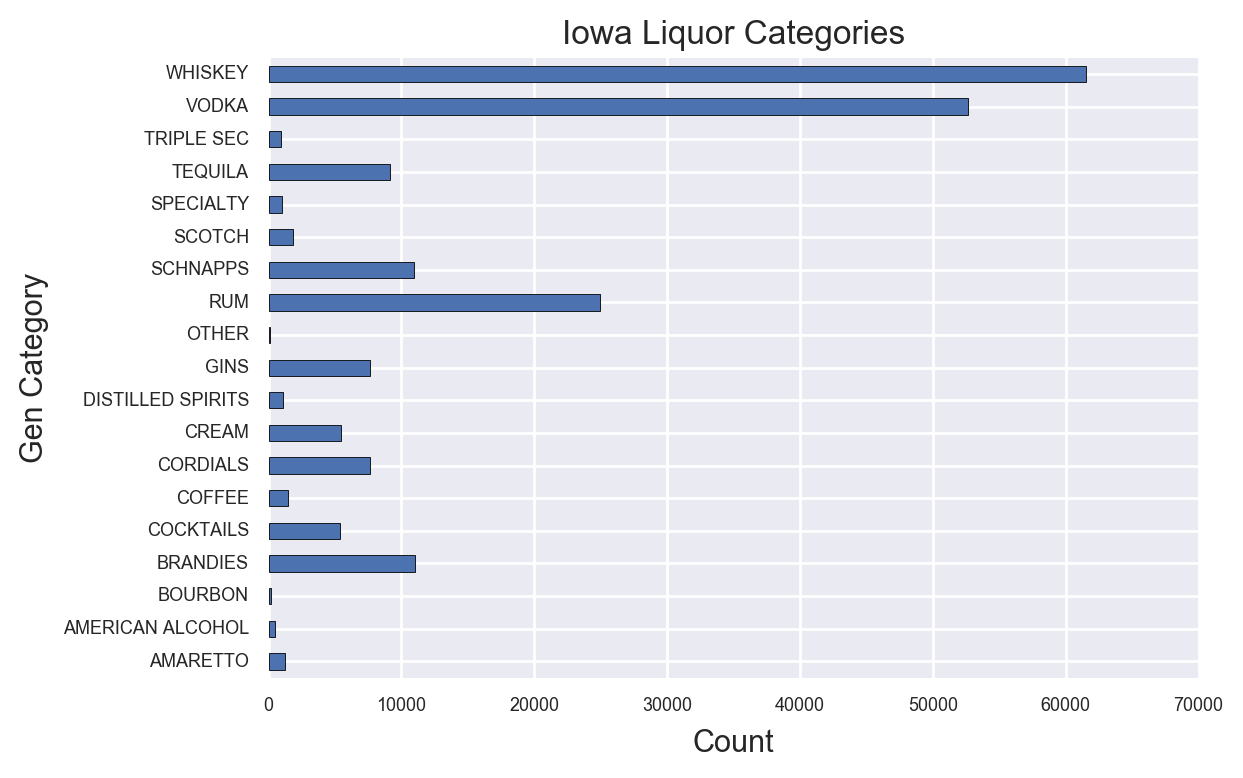

In [30]:
iowa_2015.groupby(by='Gen Category')['Gen Category'].count().plot(kind='barh', fontsize=6.5)
plt.xlabel('Count')
plt.title('Iowa Liquor Categories')
plt.show()

### Do relationships exist between the broader liquor type and profit?

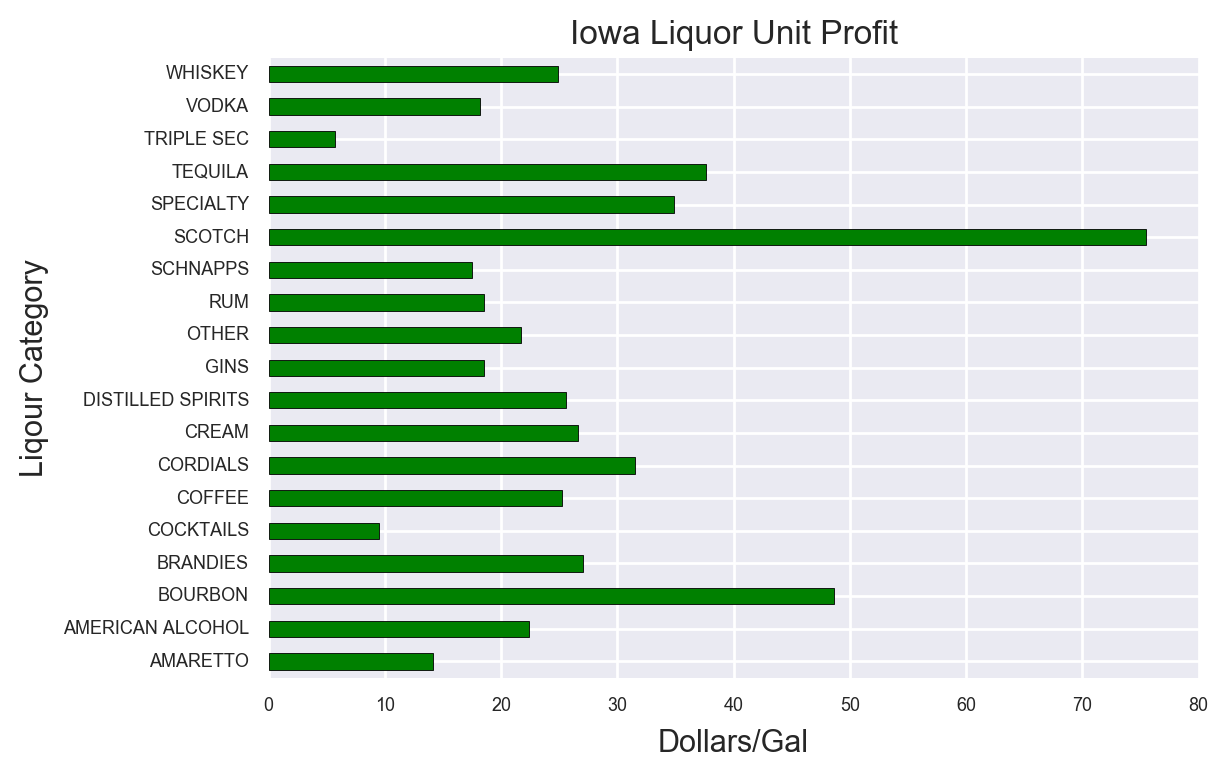

In [31]:
iowa_2015.groupby(by='Gen Category')['Profit/Gal'].mean().plot(kind='barh', fontsize=6.5, color='g')
plt.xlabel('Dollars/Gal')
plt.ylabel('Liqour Category')
plt.title('Iowa Liquor Unit Profit')
plt.show()

### The tax board wants to design a tax or taxes that affect larger stores more than smaller "mom and pop" stores.

An attempt to come up with a tax that achieves this goal without explicitely taxing stores based on size or county criteria. In this scenario, the liquo board does not want to obviously punish larger stores or specific counties for fear of backlash.

-----------------
##### Based on my preliminary analysis I don't beleive a tax of this kind would work as intended without affecting the "mom and pop" stores. The goal was to avoid taxing stores based explicitely on size or on their specific county. Instead, I explored types of liquor sold with the belief that larger stores with the most profit would generally have a greater variety. This was not the case. I then explored the idea that larger stores would generally sell more Whiskey and Bourbon (expensive liqours). 

##### Ultimately, I concluded that there is great variation in the kinds of liquor in stock regardless of a store's size. Thus, a tax targeting specigic liquors would be unwise.

In [32]:
## Attempting to compate liqour variety in stock to overall profit

iowa_liq_types = iowa_2015.groupby(by=['Store Number'])['Category Name'].nunique().reset_index()
iowa_liq_types.sort_values(by='Category Name', ascending=False)

# liq_store_profit = iowa_2015.groupby(by='Gen Category')['Profit/Gal'].mean()
liq_store_profit = iowa_2015.groupby(by='Store Number')['Profit ($)'].sum().reset_index()
liq_store_profit.sort_values(by='Store Number', ascending=False)

print iowa_liq_types.head()
print '\n'
print liq_store_profit.head()

   Store Number  Category Name
0          2106             48
1          2113             36
2          2130             46
3          2152             33
4          2178             45


   Store Number  Profit ($)
0          2106    48742.20
1          2113     3109.04
2          2130    37229.32
3          2152     2587.53
4          2178     8165.70


In [33]:
liq_type_profit = pd.merge(iowa_liq_types, liq_store_profit, left_on ='Store Number', right_on='Store Number')
liq_type_profit.rename(columns={'Category Name': 'Types Liq.'}, inplace=True)
liq_type_profit.head()

,Store Number,Types Liq.,Profit ($)
0,2106,48,48742.20
1,2113,36,3109.04
2,2130,46,37229.32
3,2152,33,2587.53
4,2178,45,8165.70


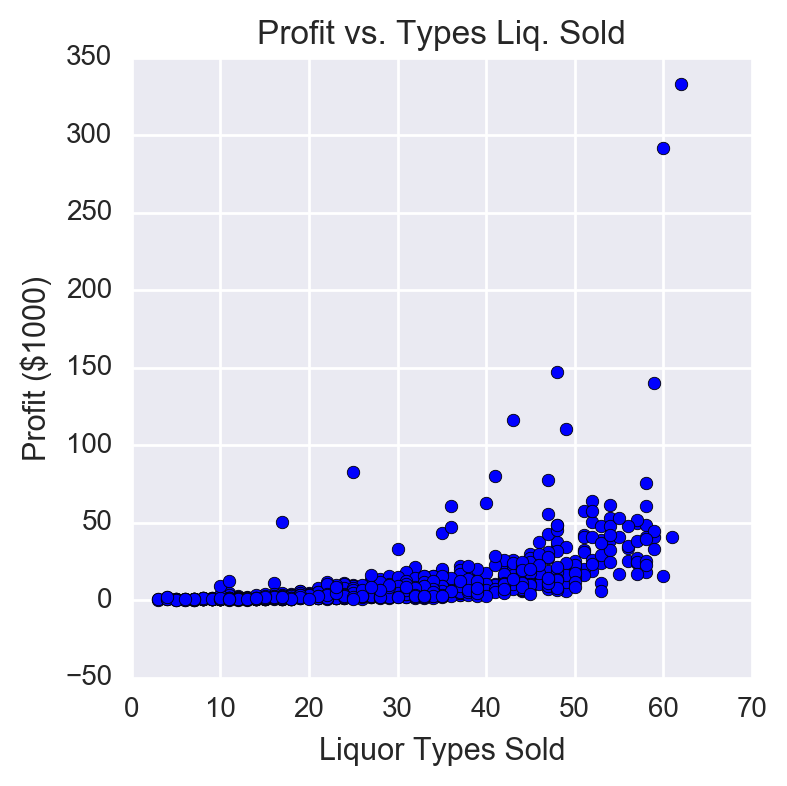

In [34]:
x = liq_type_profit['Types Liq.']
y = liq_type_profit['Profit ($)'] / float(1000)

fig, ax = plt.subplots(figsize=(4,4))

ax.set_title('Profit vs. Types Liq. Sold')
ax.set_xlabel('Liquor Types Sold')
ax.set_ylabel('Profit ($1000)')

#ax.set_ylim(0,25)

sns.plt.scatter(x,y)
plt.show()

In [35]:
liq_type_profit[['Types Liq.', 'Profit ($)']].corr()

,Types Liq.,Profit ($)
Types Liq.,1.000000,0.524438
Profit ($),0.524438,1.000000


In [ ]:
'''
An attempt to group stores by number of unique liquor
types that they sold did not yield any meaningful realtionships.

Hypothesis: 
Mom and Pop stores won't have large volumes of the
premium liquors. If you place a tax on those, then they will
directly affect the larger liquor stores.
'''

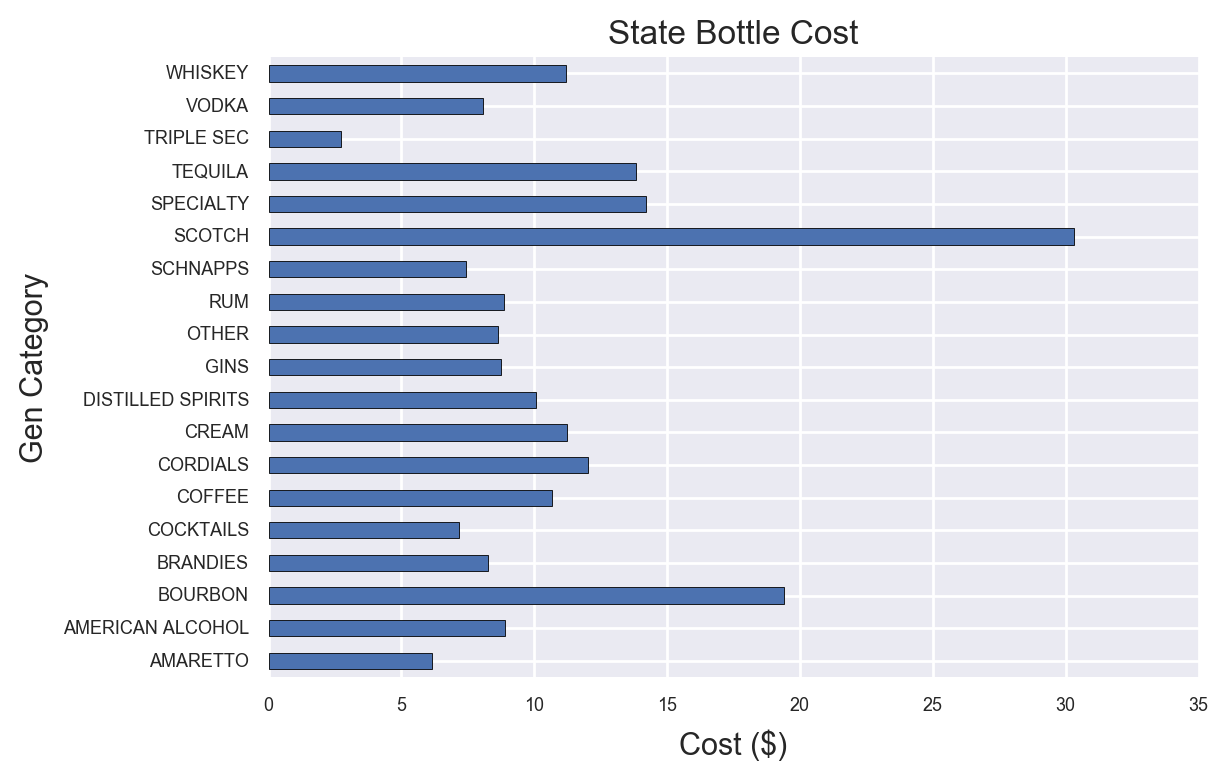

In [36]:
iowa_2015.groupby(by='Gen Category')['State Bottle Cost ($)'].mean().plot(kind='barh', fontsize=6.5)
plt.xlabel('Cost ($)')
plt.title('State Bottle Cost')
plt.show()

**SCOTCH** and **BOURBON** cost the most to purchase. Would smaller liquor stores have less of these types???

In [37]:
store_size = iowa_2015.groupby(by='Store Number')['Volume Sold (Gallons)'].sum().reset_index()

In [38]:
'''
Below I am creating a DataFrame of each store number,
it's "size" as measured by volume sold, and the number
of premium alcohol units sold (SCOTCH or BOURBON)
'''
mask = (iowa_2015['Gen Category'] == 'SCOTCH') | (iowa_2015['Gen Category'] == 'BOURBON')
num_premium_liq = iowa_2015.loc[mask,:].groupby(by='Store Number')['Gen Category'].count().reset_index()

df = pd.merge(num_premium_liq, store_size, left_on ='Store Number', right_on='Store Number')
df = df[['Store Number', 'Volume Sold (Gallons)', 'Gen Category' ]]
df.columns = ['Store Number', 'Volume Sold (Gallons)', 'Premium Liq. Sold' ]
df.head(3)

,Store Number,Volume Sold (Gallons),Premium Liq. Sold
0,2106,2568.16,6
1,2113,174.29,1
2,2190,1671.50,34


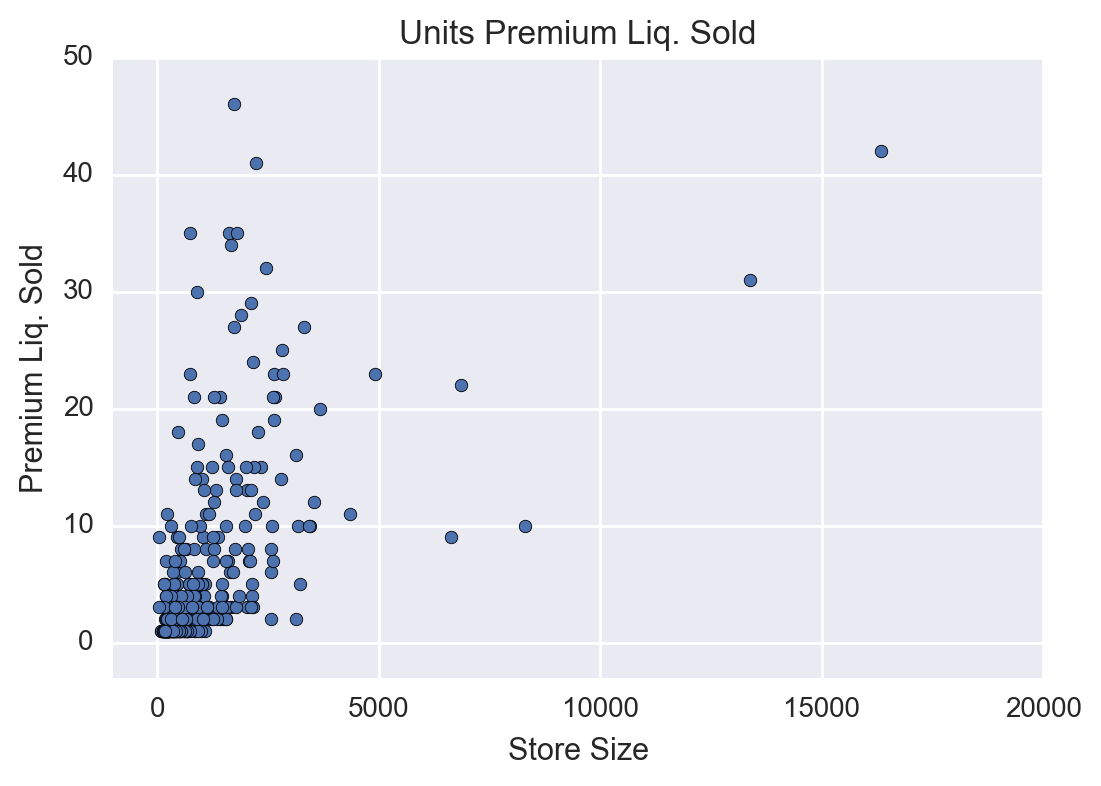

In [39]:
df.plot(kind='scatter', x='Volume Sold (Gallons)', y='Premium Liq. Sold')
plt.xlabel('Store Size')
plt.xlim(-1000, 20000)
plt.ylim(-3, 50)
plt.title('Units Premium Liq. Sold')
plt.show()

In [40]:
df[['Volume Sold (Gallons)', 'Premium Liq. Sold']].corr()

,Volume Sold (Gallons),Premium Liq. Sold
Volume Sold (Gallons),1.000000,0.555206
Premium Liq. Sold,0.555206,1.000000


### Market research for new store locations 

In this scenarios a liquor store owner in Iowa is looking to open a store in a new location and has hired me to investigate the market data for potential new locations. The business owner is interested in what you can discover from the data that will help him evaluate a good location for a new storefront.

The owner is not just interested in what locations are currently selling well, but also which areas are showing the most promising sales growth from 2015 to 2016. 

---

#### Creating columns for Q1 2015 sales and Q1 2016 sales.

In [41]:
# Creating Quarter 1 sales columns for both 2015 and 2016
# Using the Sale ($) and Date columns

mask15 = (iowa.Date >= datetime(2015,1,1)) & (iowa.Date <= datetime(2015,3,31))
mask16 = (iowa.Date >= datetime(2016,1,1)) & (iowa.Date <= datetime(2016,3,31))

iowa.loc[mask15 , 'Q1_15 ($)'] = iowa.loc[mask15 , 'Sale ($)']
iowa.loc[mask16 , 'Q1_16 ($)'] = iowa.loc[mask16 , 'Sale ($)']

In [42]:
print 'Q1_15 Total Sales: {}'.format(np.sum(iowa['Q1_15 ($)']))
print 'Q1_16 Total Sales: {}'.format(np.sum(iowa['Q1_16 ($)']))

Q1_15 Total Sales: 5866231.05
Q1_16 Total Sales: 5787962.64


In [43]:
county_q1 = iowa.groupby(by='County')[['Q1_15 ($)', 'Q1_16 ($)']].mean().reset_index()
county_q1['Growth ($)'] = county_q1['Q1_16 ($)'] - county_q1['Q1_15 ($)']
county_q1 = county_q1.sort_values(by='Growth ($)', ascending=False).reset_index(drop=True)

In [44]:
ratio = county_q1['Q1_16 ($)'] / county_q1['Q1_15 ($)']
county_q1['Growth Ratio'] = ratio

----
#### The table below is sorted by Growth in descending order. The numbers in the table are the averages in each county (i.e Liquor Stores in Crawford county had an average Q1 growth in sales of 109 USD).

In [45]:
county_q1.head()

,County,Q1_15 ($),Q1_16 ($),Growth ($),Growth Ratio
0,Crawford,94.131566,202.883370,108.751804,2.155317
1,Lee,123.978693,192.107006,68.128313,1.549516
2,Worth,86.432222,146.690800,60.258578,1.697177
3,Dallas,205.255639,250.633574,45.377936,1.221080
4,Cedar,54.873333,96.605775,41.732442,1.760523


In [46]:
# Using both Growth Ratio and Growth ($) to come up with
# a metric for growth potential

mu_x, mu_r = np.mean(county_q1['Growth ($)']), np.mean(county_q1['Growth Ratio'])
sig_x, sig_r = np.std(county_q1['Growth ($)']), np.std(county_q1['Growth Ratio'])

normal_growth = (county_q1['Growth ($)'] - mu_x)/sig_x 
normal_ratio = (county_q1['Growth Ratio'] - mu_r)/sig_r

county_q1['Metric'] = (normal_growth + normal_ratio)/2

county_q1 = county_q1.sort_values(by='Metric', ascending=False).reset_index(drop=True)

In [47]:
county_q1.head()

,County,Q1_15 ($),Q1_16 ($),Growth ($),Growth Ratio,Metric
0,Crawford,94.131566,202.883370,108.751804,2.155317,4.074019
1,Worth,86.432222,146.690800,60.258578,1.697177,2.356587
2,Lee,123.978693,192.107006,68.128313,1.549516,2.207889
3,Cedar,54.873333,96.605775,41.732442,1.760523,2.159378
4,Lucas,92.261915,131.094000,38.832085,1.420890,1.455552


### Recommendation

I would recommend **Crawford County** as it showed the best average growth according to the metric which averaged standard sales growth and standard growth ratio to account for future diminishing returns.

### Recommending a location based also on a restricted inventory type.

1. What would be the best type of liquor to sell to maximize profit?
2. Should the recommended location change if he is only selling one type of liquor?

In [48]:
county_liq_types = iowa.groupby(by=['County'])['Category Name'].nunique().reset_index()
county_liq_types.sort_values(by='Category Name', ascending=False)
county_liq_types.rename(columns={'Category Name': 'Types Liq.'}, inplace=True)

print 'Summary of Unique Liq Types by County:'
print '\n'
print county_liq_types['Types Liq.'].describe()

Summary of Unique Liq Types by County:


count    99.000000
mean     52.020202
std      10.639721
min       8.000000
25%      46.000000
50%      54.000000
75%      59.000000
max      71.000000
Name: Types Liq., dtype: float64


In [49]:
county_data = pd.merge(county_q1, county_liq_types, left_on ='County', right_on='County')

In [50]:
county_data.head()

,County,Q1_15 ($),Q1_16 ($),Growth ($),Growth Ratio,Metric,Types Liq.
0,Crawford,94.131566,202.883370,108.751804,2.155317,4.074019,56
1,Worth,86.432222,146.690800,60.258578,1.697177,2.356587,43
2,Lee,123.978693,192.107006,68.128313,1.549516,2.207889,62
3,Cedar,54.873333,96.605775,41.732442,1.760523,2.159378,52
4,Lucas,92.261915,131.094000,38.832085,1.420890,1.455552,45


In [51]:
best_liq = []
for cnty in county_data.County:
    mask = iowa.County == cnty
    max_profit = np.max(iowa.loc[mask, 'Profit ($)'])
    best_liq.append(iowa.loc[iowa['Profit ($)'] == max_profit, 'Category Name'].iloc[0,])
    
county_data['Best Liq.'] = best_liq

In [52]:
county_data.head()

,County,Q1_15 ($),Q1_16 ($),Growth ($),Growth Ratio,Metric,Types Liq.,Best Liq.
0,Crawford,94.131566,202.883370,108.751804,2.155317,4.074019,56,CANADIAN WHISKIES
1,Worth,86.432222,146.690800,60.258578,1.697177,2.356587,43,TEQUILA
2,Lee,123.978693,192.107006,68.128313,1.549516,2.207889,62,TENNESSEE WHISKIES
3,Cedar,54.873333,96.605775,41.732442,1.760523,2.159378,52,CANADIAN WHISKIES
4,Lucas,92.261915,131.094000,38.832085,1.420890,1.455552,45,IMPORTED VODKA


### The data shows that WHISKIES are the most profitable liqour in 3 of the top 5 target counties. 

---

### Time-related effects


### Hypothesis:
**People spend more on liquor during the holidays (Q4) on a per unit basis (i.e purchase more expensive liquor)**

This hypothesis is based of my gut feeling that people will have a taste for more expensive liquor for holiday parties and gifts. 

**Result:** The data shows that people genrally spend the same amount of money on a per gallon basis each quarter.

In [54]:
iowa_2015['Qtr.'] = iowa_2015.Month.apply(lambda x: int(1+ceil(x-1)/3))

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
test = iowa_2015.loc[:, ['Qtr.', 'Sale ($)', 'Volume Sold (Gallons)']]
test['$/Gal'] = iowa_2015['Sale ($)'] / iowa_2015['Volume Sold (Gallons)']
test.head()

,Qtr.,Sale ($),Volume Sold (Gallons),$/Gal
0,4,81.00,2.38,34.033613
4,3,129.60,5.55,23.351351
5,2,119.88,2.77,43.277978
6,3,29.97,0.59,50.796610
7,2,47.26,0.92,51.369565


In [56]:
q1 = test.loc[test['Qtr.'] == 1, '$/Gal']
q2 = test.loc[test['Qtr.'] == 2, '$/Gal']
q3 = test.loc[test['Qtr.'] == 3, '$/Gal']
q4 = test.loc[test['Qtr.'] == 4, '$/Gal']

data = [q1, q2, q3, q4]

print q1.max(), q2.max(), q3.max(), q4.max()

3187.5 2624.95 1813.84615385 1846.15384615


In [57]:
q1_info = q1.describe().reset_index()
q1_info.columns = ['Info', 'Q1 $/Gal']

q2_info = q2.describe().reset_index()
q2_info.columns = ['Info', 'Q2 $/Gal']

q3_info = q3.describe().reset_index()
q3_info.columns = ['Info', 'Q3 $/Gal']

q4_info = q4.describe().reset_index()
q4_info.columns = ['Info', 'Q4 $/Gal']

# Merge Tables together
q12 = pd.merge(q1_info, q2_info, left_on ='Info', right_on='Info')
q123 = pd.merge(q12, q3_info, left_on ='Info', right_on='Info')
q1234 = pd.merge(q123, q4_info, left_on ='Info', right_on='Info')

In [58]:
q1234.set_index(['Info']).T

Info,count,mean,std,min,25%,50%,75%,max
Q1 $/Gal,46969.0,67.309614,49.876023,12.075472,35.869565,56.216898,85.135647,3187.500000
Q2 $/Gal,52045.0,67.813872,50.673560,12.113565,36.300000,56.430380,85.135647,2624.950000
Q3 $/Gal,51398.0,66.840699,47.528742,10.436975,36.104251,56.200000,84.075000,1813.846154
Q4 $/Gal,54154.0,69.856032,52.218463,10.447950,37.537906,56.722689,86.924370,1846.153846


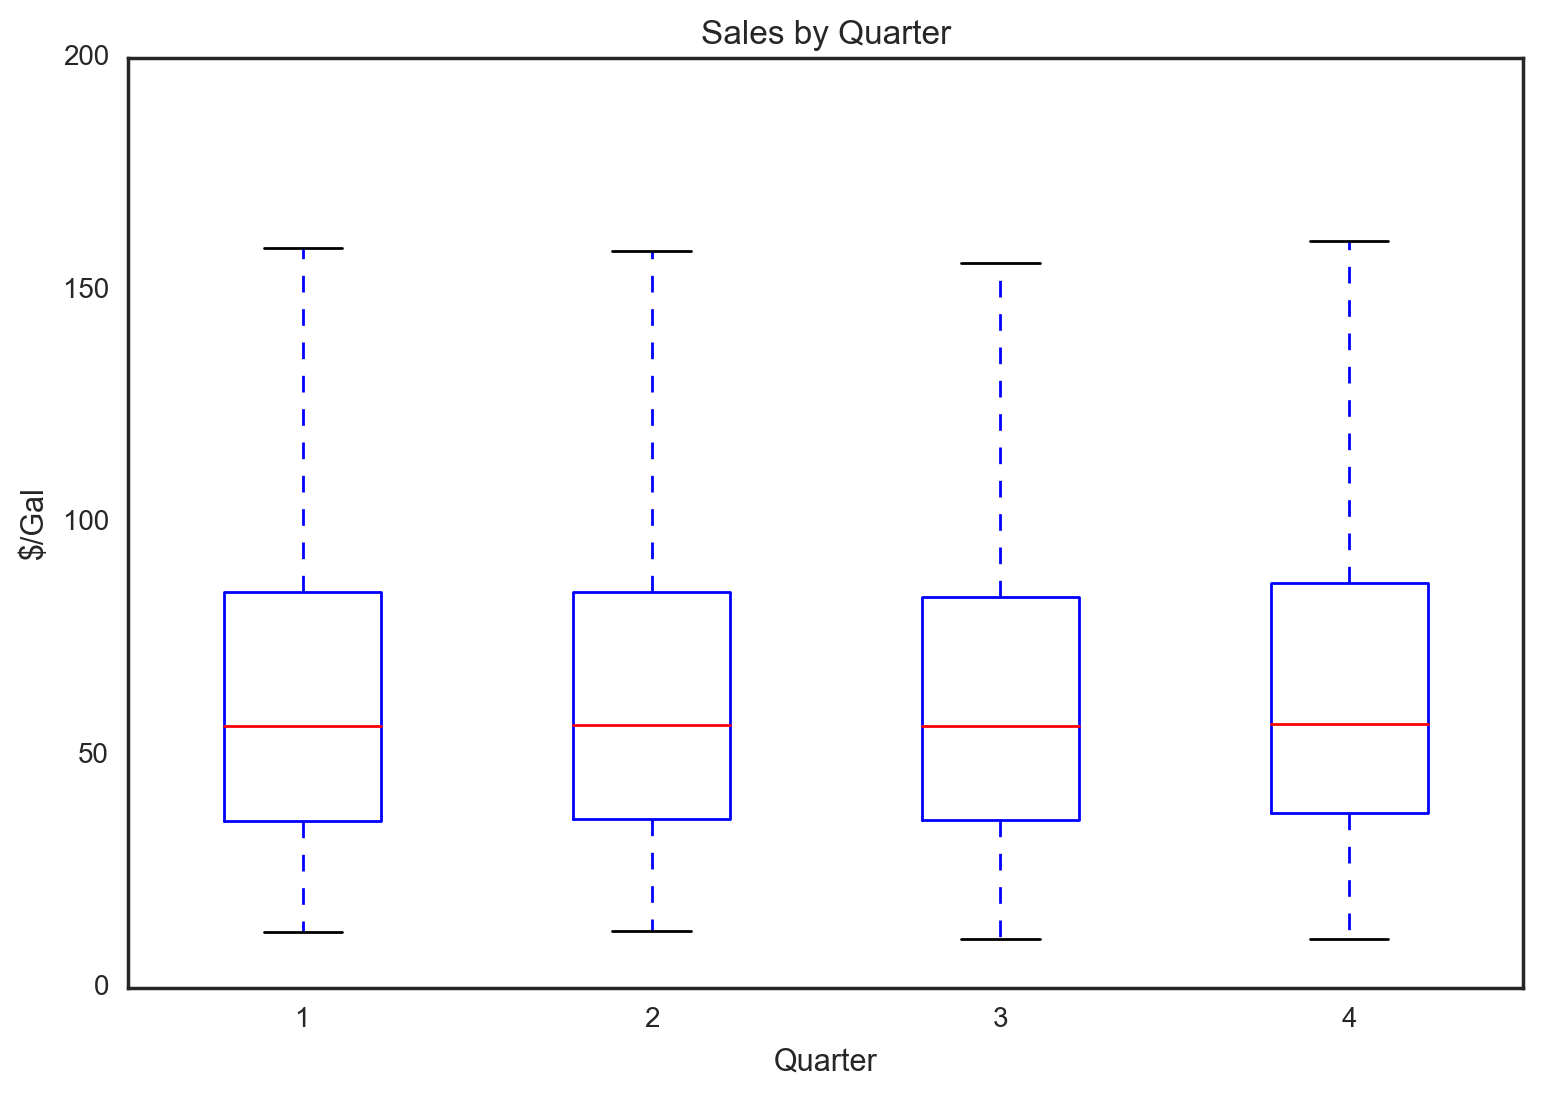

In [59]:
fig = plt.figure(1, figsize=(9, 6))

sns.set_style("white")

# Create an axes instance
ax = fig.add_subplot(111)

ax.set_title('Sales by Quarter')
ax.set_xlabel('Quarter')
ax.set_ylabel('$/Gal')

ax.set_ylim(0,200)

ax.boxplot(data)

plt.show()

### Appropriate Spending

---

Figuring out how much this store owner should be willing to spend on opening his store.

### Calculate costs and time to recoup.

Conditions: 

* The owner decides to buy 20,000 gallons of the liquor type I recommended.  He is also opening his store in the area I recommended.

* The cost of buying the property for his store will be $150,000.

In [61]:
mask = (iowa_2015['Gen Category'] == 'WHISKEY') & (iowa_2015['County'] == 'Crawford')

print 'Crawford', 'WHISKEY'
print iowa_2015.loc[mask, :].shape
print 'Purchase 20,000 gals. = 75,708,236 ml'
print 'Store Cost: $150,000'

# General Crawford sales figures
crawford_sales =  iowa_2015.loc[iowa_2015.County == 'Crawford', 'Sale ($)'].sum()
crawford_stores = len(iowa_2015.loc[iowa_2015.County == 'Crawford', 'Store Number'].unique())

print '\n'
print '2015 Sales per Store: {}'.format(round(crawford_sales/crawford_stores,2))

Crawford WHISKEY
(294, 21)
Purchase 20,000 gals. = 75,708,236 ml
Store Cost: $150,000


2015 Sales per Store: 28358.32


In [62]:
cols = ['Bottle Volume (ml)', 'State Bottle Cost ($)', 'State Bottle Retail ($)', 'Category Name', 'Gen Category']
iowa_2015.loc[mask, cols].head()

,Bottle Volume (ml),State Bottle Cost ($),State Bottle Retail ($),Category Name,Gen Category
74,1000,12.59,18.89,STRAIGHT BOURBON WHISKIES,WHISKEY
725,1000,18.38,27.57,TENNESSEE WHISKIES,WHISKEY
898,1000,7.08,10.62,BLENDED WHISKIES,WHISKEY
1408,750,6.16,9.24,STRAIGHT BOURBON WHISKIES,WHISKEY
3293,375,5.33,8.00,WHISKEY LIQUEUR,WHISKEY


In [63]:
# 50 Gallons = 189271 ml
# 25 Gallons = 94635.3 ml
94635.3 / iowa_2015.loc[mask, 'Bottle Volume (ml)'].mean()

90.45851645940014

In [64]:
# Takes ~7 secs to run
df_sample = iowa_2015.loc[mask, cols].sample(90, replace=True)
a = [df_sample.loc[:, 'Bottle Volume (ml)'].sum()]

while sum(a) < 75708236:
    smple = iowa_2015.loc[mask, cols].sample(90, replace=True)
    a.append(smple.loc[:, 'Bottle Volume (ml)'].sum())
    
    dfs = (df_sample, smple)
    df_sample = pd.concat(dfs, ignore_index=True)

In [65]:
volume = df_sample['Bottle Volume (ml)'].sum()/ 3785.41
cost = df_sample['State Bottle Cost ($)'].sum()

print 'Volume: {} gal'.format(int(volume))
print 'Cost  : ${}'.format(int(cost))

Volume: 20009 gal
Cost  : $815393


In [66]:
tot_cost = cost + 150000
print 'Initial Investment: ${}'.format(tot_cost)

Initial Investment: $965393.58


In [67]:
## ASSUMPTION: 2X growth rate sustained each year

sales = round(crawford_sales/crawford_stores, 2)
lst = [sales]
revenue = sum(lst)
n = 2 # Growth Ratio
r = [n]
while revenue < tot_cost:
    sales *= n
    r.append(round(n,2))
    lst.append(sales)
    revenue = sum(lst)

In [68]:
print 'Years: {} Revenue: {}'.format(len(lst[:-1]), sum(lst[:-1]))
print 'Years: {} Revenue: {}'.format(len(lst), sum(lst[:]))
print 'Yearly Sales: {}'.format(lst)
print 'Annual Growth Ratios: {}'.format(r)

Years: 5 Revenue: 879107.92
Years: 6 Revenue: 1786574.16
Yearly Sales: [28358.32, 56716.64, 113433.28, 226866.56, 453733.12, 907466.24]
Annual Growth Ratios: [2, 2.0, 2.0, 2.0, 2.0, 2.0]


In [69]:
## ASSUMPTION: 2X growth rate NOT sustained each year
## Growth is diminished each year until steady state reached

sales = round(crawford_sales/crawford_stores, 2)
lst = [sales]
revenue = sum(lst)
n = 2 # Growth Ratio
r = [n]
while revenue < tot_cost:
    if n < 1:
        n = 1
    sales *= n
    r.append(round(n,2))
    lst.append(sales)
    revenue = sum(lst)
    n -= 0.20

In [70]:
print 'Years: {} Revenue: {}'.format(len(lst[:-1]), sum(lst[:-1]))
print 'Years: {} Revenue: {}'.format(len(lst), sum(lst[:]))
print 'Yearly Sales: {}'.format(lst)
print 'Annual Growth Ratios: {}'.format(r)

Years: 6 Revenue: 853608.118656
Years: 7 Revenue: 1128025.90963
Yearly Sales: [28358.32, 56716.64, 102089.952, 163343.92320000002, 228681.49248000004, 274417.7909760001, 274417.79097600013]
Annual Growth Ratios: [2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0]


### Calculating maximum loan interest rate.

The owner unfortunately has to take out a loan to to pay for the entirety of the property and liquor. 

**Conditions of the loan**:

Every quarter, (except for Q1 when he takes out the loan), the interest rate is applied to the remaining balance on the loan and added to his debt. 


**Determining maximum acceptable interest:**

Based on his expected profits per quarter (assume the expected profit stays the same for all future quarters), what is the maximum interest rate he should accept on the loan?

------
#### Given the initial size of the investment spending $150,000 plus buying 20,000 gallons of liqour it seems very unlikely that this store owner will avoid declaring bankruptcy with a loan interest above 0.3%. 
_____

In [71]:
sales = round(crawford_sales/crawford_stores, 2)
print '\n'
print '2015 Crawford Sales Q1: ${} \n'.format(sales/4)
print 'Expected Growth Ratio: 2 \n'
print 'Assume Starting Point for New Store: ${} \n'.format(2*sales/4)
print 'Quarterly Revenue = Q_Rev * 2^(1/4) \n'



2015 Crawford Sales Q1: $7089.58 

Expected Growth Ratio: 2 

Assume Starting Point for New Store: $14179.16 

Quarterly Revenue = Q_Rev * 2^(1/4) 



In [72]:
n = 2 # Expected Growth Ratio
revenue = n*(sales / 4)
bal = tot_cost

i = 0.003 # Interest
q = 1 # Initial Quarter
quarters, loan_balance, q_revenues = [q], [bal], [revenue]

for _ in range(40):
    bal *= (1+i)**q
    q += 1
    revenue *= n**(0.25)
    quarters.append(q)
    loan_balance.append(bal)
    q_revenues.append(revenue)

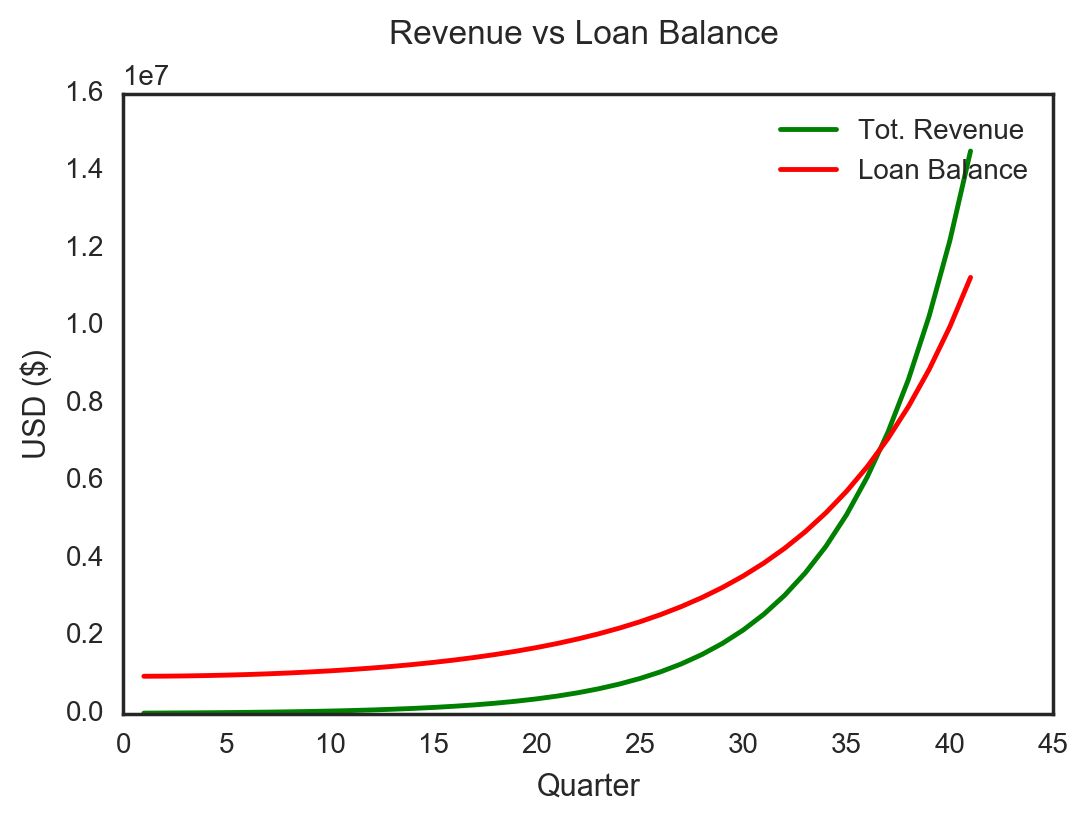

In [73]:
x , y1 , y2 = quarters, loan_balance, q_revenues

plt.plot(x, y2, label='Tot. Revenue', color='g') # Revenue
plt.plot(x, y1, label='Loan Balance', color='r') # Loan Balance

plt.xlim(0,45)
plt.xlabel('Quarter')
plt.ylabel('USD ($)')
plt.title('Revenue vs Loan Balance \n')


plt.legend()
plt.show()